In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stylia as st
from stylia import NamedColors

colors=NamedColors()

color_dict ={"arv": colors.blue,
             "coad": colors.orange,
             "mtb": colors.green}

datapath = "../data"
outpath = "../output"

In [10]:
datasets = ["arv", "coad", "mtb"]
dfs = []
for d in datasets:
    df = pd.read_csv(os.path.join(outpath, "results", f"{d}_drugs.csv"))
    indication = d
    df["indication"] = indication
    dfs += [df]

df = pd.concat(dfs)
df.shape

(115, 9)

In [11]:
entry = ["coad_entry", "arv_entry", "mtb_entry"]
dfs = []
for d in entry:
    df_ = pd.read_csv(os.path.join(outpath, "results", f"{d}.csv"))
    indication = d.split("_")[0]
    df_["indication"] = indication
    dfs += [df_]
df_entry = pd.concat(dfs)
df_entry.rename(columns={"smiles":"name"}, inplace=True)

df = df.merge(df_entry[["name","rb", "glob", "pbf", "primary_amine"]], on=["name"])
df.rename(columns={"rb":"entry_rb", "glob":"entry_glob", "pbf":"entry_pbf", "primary_amine":"entry_amine"}, inplace=True)

In [12]:
df.columns

Index(['name', 'smiles', 'indication', 'sarathy2016', 'janardhan2016',
       'radchenko2023', 'lepori2025_mtb', 'lepori2025_msm', 'mycpermcheck',
       'entry_rb', 'entry_glob', 'entry_pbf', 'entry_amine'],
      dtype='object')

In [13]:
import numpy as np

df["entry_amine"]=df.entry_amine.replace({True:1, False:0})
entry = {
    "entry_rb": (4, "l"),
    "entry_glob": (0.2, "l"),
    "entry_pbf": (1, "l"),
    "entry_amine": (0.5, "h")
}

bools = np.zeros(shape=(len(entry),len(df)))

a=0
for k,v in entry.items():
    for c in df.columns.tolist():
        if k==c:
            v, d = v
            if d == "l":
                b = np.where(df[c]<=v, True, False)
            else:
                b = np.where(df[c]>=v, True, False)
            bools[a]=b
            a = a+1
df["entry_score"]=bools.sum(axis=0)

/tmp/ipykernel_628399/2084829542.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["entry_amine"]=df.entry_amine.replace({True:1, False:0})


In [16]:
df.to_csv(os.path.join(outpath, "results", "allpreds.csv"), index=False)

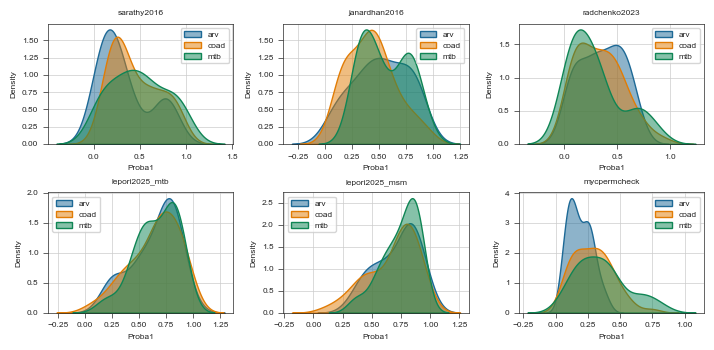

In [14]:
models = ["sarathy2016", "janardhan2016", "radchenko2023", "lepori2025_mtb", "lepori2025_msm", "mycpermcheck"]

fig, axs=st.create_figure(2,3)
for m in models:
    ax = axs.next()
    for d in datasets:
        df_ = df[df["indication"]==d]
        sns.kdeplot(ax=ax, x = df_[m].tolist(), color=color_dict[d], label=d, alpha=0.5, fill=True)
    ax.set_title(f"{m}")  
    ax.set_xlabel("Proba1")
    ax.set_ylabel("Density")
    ax.legend()
plt.tight_layout()
st.save_figure(os.path.join(outpath, "plots", "prediction_distribution.png"))

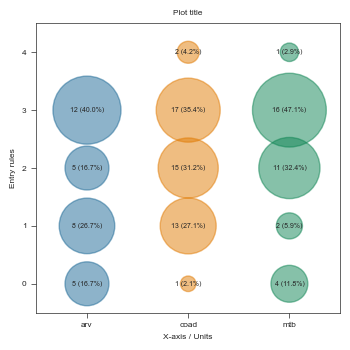

In [52]:
import collections
import stylia as st
import matplotlib.pyplot as plt
from stylia import NamedColors

colors=NamedColors()

color_dict ={"arv": colors.blue,
             "coad": colors.orange,
             "mtb": colors.green}

entry_counts = collections.defaultdict(int)

for r in df[["indication", "entry_score"]].values:
    entry_counts[(r[0], r[1])] += 1

fig, axs = st.create_figure(1,1)
ax = axs.next()
for i, ind in enumerate(["arv", "coad", "mtb"]):
    x = []
    y = []
    z = []
    for k,v in entry_counts.items():
        if k[0] != ind: continue
        x += [i]
        y += [k[1]]
        z += [v]
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    z_ = z/np.sum(z)
    ax.scatter(x, y, s=z_*6000, alpha=0.5,color=color_dict[ind])
    for j in range(len(x)):
        ax.text(x[j], y[j], "{0} ({1}%)".format(z[j], round(z_[j]*100,1)), va="center", ha="center")
ax.set_yticks([j for j in range(5)])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["arv", "coad", "mtb"])
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 4.5)
ax.grid()
ax.set_ylabel("Entry rules")

plt.tight_layout()

st.save_figure(os.path.join(outpath,"plots", "entry_rules.png"))

In [55]:
def stripplot_graph(df, model, ax):
    palette = {
        "arv": colors.blue,
        "coad": colors.orange,
        "mtb": colors.green
    }
    sns.stripplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, size=3, palette=palette)
    PROPS = {
        'boxprops':{'facecolor':'none', 'edgecolor':'black'},
        'medianprops':{'color':'black'},
        'whiskerprops':{'color':'black'},
        'capprops':{'color':'black'}
    }
    sns.boxplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, color="white", linewidth=1, **PROPS)
    ax.set_title(model)
    ax.set_ylabel("")
    ax.set_xlabel("")

/tmp/ipykernel_70330/4108155502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, size=3, palette=palette)
/tmp/ipykernel_70330/4108155502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, size=3, palette=palette)
/tmp/ipykernel_70330/4108155502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="indication", y=model, data=df, order=["arv", "coad", "mtb"], ax=ax, size=3, palette=palette)
/

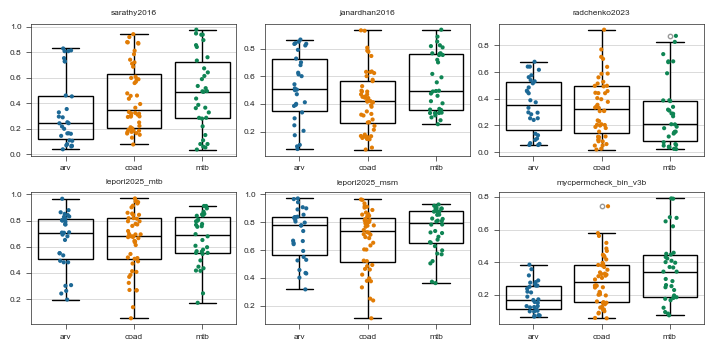

In [56]:
models = ["sarathy2016", "janardhan2016", "radchenko2023", "lepori2025_mtb", "lepori2025_msm", "mycpermcheck_bin_v3b"]
fig, axs = st.create_figure(2,3)
for m in models:
    ax = axs.next()
    stripplot_graph(df, m, ax)
    plt.tight_layout()
st.save_figure(os.path.join(outpath,"plots", "preds_eval.png"))